In [658]:
import pymysql
import snscrape.modules.twitter as sntwitter
import pandas as pd
from sqlalchemy import create_engine
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import plotly.graph_objects as go
from wordcloud import STOPWORDS
from collections import defaultdict
import plotly.offline as py
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.feature_extraction.text import CountVectorizer
import plotly.express as px

In [659]:
# Collect all the tweets fromo November to March 2023, which tags @ThebridgeTech

query = '-from:TheBridge_Tech(@TheBridge_Tech) until:2023-03-07 since:2022-11-21'
tweets = []
limit = 500

for tweet in sntwitter.TwitterSearchScraper(query).get_items():

    #print(vars(tweet))
    #break
    if len(tweets) == limit :
        break
    else:
        tweets.append([tweet.id, tweet.content, tweet.date, tweet.user.id, tweet.user, tweet.user.username, tweet.replyCount, tweet.retweetCount, tweet.likeCount, tweet.quoteCount])

df = pd.DataFrame(tweets, columns=['Id del mensaje', 'Tweets', 'Fecha del tweet', 'Id del autor', 'Nombre del autor', 'Nombre de usuario', 'Respuestas', 'Retweets', 'Likes', 'Citas'])
df.head()

/var/folders/fh/hxrrvrn15b5_v0bjv8nbpw2w0000gp/T/ipykernel_17625/1073248621.py:14: DeprecatedFeatureWarning:

content is deprecated, use rawContent instead



,Id del mensaje,Tweets,Fecha del tweet,Id del autor,Nombre del autor,Nombre de usuario,Respuestas,Retweets,Likes,Citas
0,1632692123412594688,Las inscripciones se realizarán por Eventbrite...,2023-03-06 10:38:30+00:00,1585726199485140993,https://twitter.com/ESOLIUPO,ESOLIUPO,0,0,0,0
1,1632692120719859712,¡Por fin podemos publicar el cartel con los po...,2023-03-06 10:38:30+00:00,1585726199485140993,https://twitter.com/ESOLIUPO,ESOLIUPO,1,3,5,1
2,1632664546665025536,"Encuentro de la @mlopscommunity en Madrid: ""ML...",2023-03-06 08:48:56+00:00,41545659,https://twitter.com/nodosenlared,nodosenlared,0,1,3,0
3,1632147141224275970,@nodosenlared @snowded @TheBridge_Tech Muy bue...,2023-03-04 22:32:56+00:00,925597948410580993,https://twitter.com/RoccoLozano,RoccoLozano,0,0,1,0
4,1632020293509083137,@PauMugarra @ToniDorta @TheBridge_Tech https:/...,2023-03-04 14:08:54+00:00,276656109,https://twitter.com/joobid,joobid,0,0,2,0


In [660]:
df.to_csv('src/data/Twitter.csv', index=False)

In [661]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   Id del mensaje     128 non-null    int64              
 1   Tweets             128 non-null    object             
 2   Fecha del tweet    128 non-null    datetime64[ns, UTC]
 3   Id del autor       128 non-null    int64              
 4   Nombre del autor   128 non-null    object             
 5   Nombre de usuario  128 non-null    object             
 6   Respuestas         128 non-null    int64              
 7   Retweets           128 non-null    int64              
 8   Likes              128 non-null    int64              
 9   Citas              128 non-null    int64              
dtypes: datetime64[ns, UTC](1), int64(6), object(3)
memory usage: 10.1+ KB


# DATA ANALYSIS

In [662]:
# Sum all important metrics 
df['Engagement'] = df.apply(lambda row: row[-4:].sum(),axis=1)

# Split the date

df['new_date'] = [d.date() for d in df['Fecha del tweet']]
df['new_time'] = [d.time() for d in df['Fecha del tweet']]

# Let's get advantage of hours, days and months
df['hour'] = [d.hour for d in df['new_time']]
df['month'] = [d.month for d in df['new_date']]
df['day'] = [d.strftime('%A') for d in df['new_date']]


1. Which is the most engagement tweet ?

In [663]:
# Let's show how is the engagement

engagement = df[['Nombre de usuario','Tweets','Engagement']].sort_values('Engagement' , ascending=False)[:15]
engagement

,Nombre de usuario,Tweets,Engagement
65,nodosenlared,"Advanced #Cynefin, Estuarine mapping &amp; EUF...",385
60,Recuenco,En plena meet-up de CPS en @TheBridge_Tech con...,43
10,decentralized_b,Este 14 de Marzo hay meetup en Madrid de @Bitc...,35
7,decentralized_b,Ya esta publicado el meetup de @BitcoinTuesday...,16
14,42UrdulizFTef,".@EstiLeon, Responsable del campus #42UrdulizF...",16
64,nodosenlared,@snowded @TheBridge_Tech Se trata de un taller...,16
5,PauMugarra,El meetup del jueves 9 de marzo con @ToniDorta...,14
104,Infolagun,Open Day #Bilbao para conocer un #bootcam\n🗓️ ...,14
43,42UrdulizFTef,"💥 Llega la @globalgamejam , a #42UrdulizFTef, ...",13
17,BitcoinTuesday_,Gracias a nuestros amigos @TheBridge_Tech por ...,13


In [664]:
fig = px.bar(engagement, y='Engagement', x='Nombre de usuario',text=engagement['Engagement'],
            title="Interaccion de los usuarios por tweet")
fig.show()


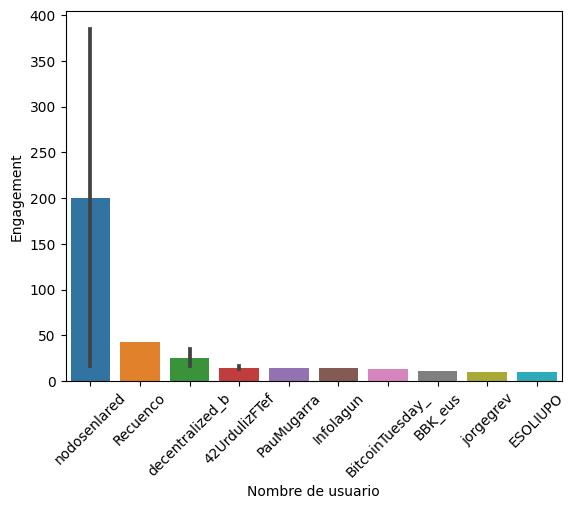

In [665]:
sns.barplot(x = engagement['Nombre de usuario'], y = engagement['Engagement'])
plt.xticks(rotation = 45);

This is the author of the tweet with most engagement from the date checked

2. Let's see who is the user that most mentioned to The Bridge 

In [666]:
# Groupby with users  and count of times

users = df.groupby('Nombre de usuario')['Nombre de usuario'].count(). sort_values(ascending=False).head(8)
users

Nombre de usuario
BBK_eus            22
jorgegrev          11
EDEMempresarios     4
Recuenco            4
Godivaciones        4
EditaOla            4
PauMugarra          4
BitcoinTuesday_     4
Name: Nombre de usuario, dtype: int64

In [667]:
fig = px.bar(users,x = users.index,y = users.values,text=users.values,
            title="Menciones a The Bridge")
fig.update_xaxes(title = 'Users')
fig.update_yaxes(title = 'Menciones')
fig.show()

As we can see the top 5 is handle by itself , BBK and active user as jorgegrev, who is the most active in this period.

3. Let's see which month is the most activity

In [668]:
# Groupby with the most important month talking about tweets
month = df.groupby('month')['month'].count().sort_values(ascending=False)
month

month
1     49
11    27
12    23
2     17
3     12
Name: month, dtype: int64

In [669]:
dict = {1:'Enero',2:'Febrero',3:'Marzo',11:'Noviembre',12:'Diciembre'}
#df = px.data.tips()
fig = px.pie(month, values=month.values, names=month.index.map(dict))
fig.show()

In [671]:
# Group by with the most important day talking about tweets

day = df.groupby('day')['day'].count().sort_values(ascending=False)
day

day
Wednesday    42
Thursday     29
Tuesday      18
Friday       17
Monday       14
Saturday      6
Sunday        2
Name: day, dtype: int64

In [672]:
fig = px.bar(day,x = day.index,y = day.values,text=day.values,
            title="Día con más Tweets mencionando a The Bridge")
fig.update_xaxes(title = 'Days', dtick =[(1,2,3,11,12)])
fig.update_yaxes(title = 'Tweets')
fig.show()

In [673]:
hour = df.groupby('hour')['hour'].count().sort_values(ascending=False)

In [674]:
fig = px.bar(hour,x = hour.index,y = hour.values,text=hour.values,
            title="Hora con más Tweets mencionando a The Bridge")
fig.update_xaxes(title = 'Hour', dtick =[(1,2,3,11,12)])
fig.update_yaxes(title = 'Tweets')
fig.show()

As we can see January has been the most active month, it's ready to check it out deeply. In the other hand, Wednesday is the most active day during the week from the date selected.

4. The most common word

In [675]:
spanish_stopwords = stopwords.words('spanish')

def remove_stopwords(df):
    return " ".join([word for word in df.split() if word not in spanish_stopwords])

def spanish_stemmer(x):
    stemmer = SnowballStemmer('spanish')
    return " ".join([stemmer.stem(word) for word in x.split()])

def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

df['script'] = df['Tweets'].apply(remove_stopwords)
#df['script'] = df['Tweets'].apply(spanish_stemmer)
#df['script'].head()

In [676]:
freq_dict = defaultdict(int)
for sent in df["script"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1][:25], columns=["word", "wordcount"])
fd_sorted
trace0 = go.Bar(
    x=fd_sorted["wordcount"][::-1],
    y=fd_sorted["word"][::-1],
    orientation='h'
)
fig = go.Figure(trace0)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots')

As we see, this is how the common words works

5. Correlation between diferent metrics

In [677]:
# Convert to string 
df['Id del mensaje']=df['Id del mensaje'].astype(str)

# Map the days for numeric values
dict = {'Monday':1, 'Tuesday':2, 'Wednesday':3, 'Thursday':4, 'Friday':5, 'Saturday':6, 'Sunday':7}
df['number_day'] = df['day'].map(dict)

<Axes: >

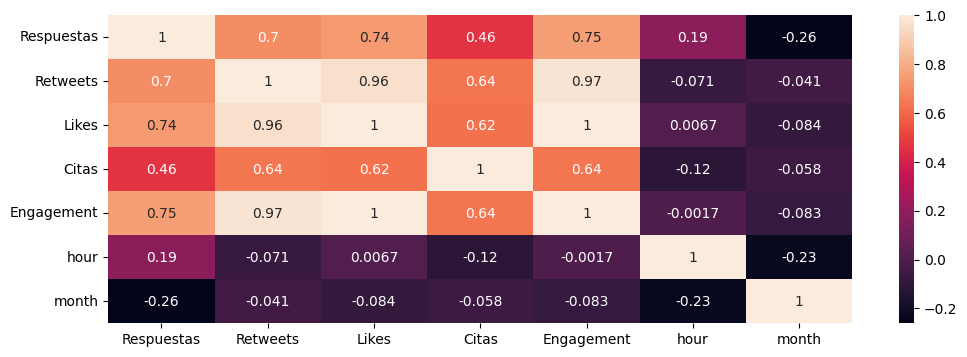

In [678]:
plt.figure(figsize=(12,4))
sns.heatmap(df[['Respuestas','Retweets','Likes','Citas','Engagement','hour','month']].corr(), annot=True)

As we can see, there are different correlation between different features, Retweets and likes have strong correlation , because obviously facts.

But there are not strong correlation, with other features.

In addition, I showed that Wednesday is the most engagement day of the week. As important fact, along 8 and 9 in the morning is the range of the most engagement active.

So, in the future we can analyze this two fact because they are so important in some bussines.

# TRAINING

1. Predictions

In [679]:
with open('src/model/sentiment_model', "rb") as archivo_entrada:
    pipeline_importada = pickle.load(archivo_entrada)

/Users/migueldefrutos/miniconda3/lib/python3.10/site-packages/sklearn/base.py:299: UserWarning:

Trying to unpickle estimator CountVectorizer from version 1.0.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations

/Users/migueldefrutos/miniconda3/lib/python3.10/site-packages/sklearn/base.py:299: UserWarning:

Trying to unpickle estimator LogisticRegression from version 1.0.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations

/Users/migueldefrutos/miniconda3/lib/python3.10/site-packages/sklearn/base.py:299: UserWarning:

Trying to unpickle estimator Pipeline from version 1.0.2 when using version 1.2.1. This might lead to breaking code or invalid r

In [680]:
pipeline_importada

Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.5, max_features=1000, min_df=5,
                                 ngram_range=(1, 2))),
                ('cls', LogisticRegression(C=0.5))])

In [681]:
predictions = pipeline_importada.predict(df['Tweets'])
df['Feeling'] = pd.Series(predictions)
df[['Tweets','script','Feeling']]

,Tweets,script,Feeling
0,Las inscripciones se realizarán por Eventbrite...,Las inscripciones realizarán Eventbrite. Cualq...,0
1,¡Por fin podemos publicar el cartel con los po...,¡Por fin podemos publicar cartel ponentes #cyb...,1
2,"Encuentro de la @mlopscommunity en Madrid: ""ML...","Encuentro @mlopscommunity Madrid: ""MLOPs: trin...",1
3,@nodosenlared @snowded @TheBridge_Tech Muy bue...,@nodosenlared @snowded @TheBridge_Tech Muy bue...,0
4,@PauMugarra @ToniDorta @TheBridge_Tech https:/...,@PauMugarra @ToniDorta @TheBridge_Tech https:/...,0
...,...,...,...
123,@Cyber_Madrid organiza el I Congreso de #Cibe...,@Cyber_Madrid organiza I Congreso #Ciberseguri...,0
124,🔵Acelera tu carrera digital con #BBKBootcamps....,🔵Acelera carrera digital #BBKBootcamps. Gracia...,1
125,Acelerando juntos el #talentodigital en España...,Acelerando juntos #talentodigital España. El p...,0
126,"Ikasi gaur etorkizuneko lanbideak, izena eman ...","Ikasi gaur etorkizuneko lanbideak, izena eman ...",1


In [682]:
predicions_proba = pipeline_importada.predict_proba(df['Tweets'])
predicions_proba

array([[0.51901694, 0.48098306],
       [0.40379759, 0.59620241],
       [0.21567168, 0.78432832],
       [0.54376377, 0.45623623],
       [0.54745853, 0.45254147],
       [0.51529556, 0.48470444],
       [0.73246715, 0.26753285],
       [0.51456081, 0.48543919],
       [0.58760061, 0.41239939],
       [0.54745853, 0.45254147],
       [0.43116739, 0.56883261],
       [0.54745853, 0.45254147],
       [0.47835499, 0.52164501],
       [0.70028848, 0.29971152],
       [0.23255407, 0.76744593],
       [0.44996338, 0.55003662],
       [0.54745853, 0.45254147],
       [0.91928196, 0.08071804],
       [0.44289636, 0.55710364],
       [0.51033272, 0.48966728],
       [0.52724888, 0.47275112],
       [0.78972669, 0.21027331],
       [0.54745853, 0.45254147],
       [0.54745853, 0.45254147],
       [0.54745853, 0.45254147],
       [0.54745853, 0.45254147],
       [0.39064124, 0.60935876],
       [0.61146036, 0.38853964],
       [0.60360588, 0.39639412],
       [0.60360588, 0.39639412],
       [0.

In [683]:
feeling = df[['Tweets','script','Feeling']]
feeling['Polarity_Pos'] = predicions_proba[:,1]
feeling['Polarity_Neg'] = predicions_proba[:,0]
feeling

/var/folders/fh/hxrrvrn15b5_v0bjv8nbpw2w0000gp/T/ipykernel_17625/2256110331.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/fh/hxrrvrn15b5_v0bjv8nbpw2w0000gp/T/ipykernel_17625/2256110331.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Tweets,script,Feeling,Polarity_Pos,Polarity_Neg
0,Las inscripciones se realizarán por Eventbrite...,Las inscripciones realizarán Eventbrite. Cualq...,0,0.480983,0.519017
1,¡Por fin podemos publicar el cartel con los po...,¡Por fin podemos publicar cartel ponentes #cyb...,1,0.596202,0.403798
2,"Encuentro de la @mlopscommunity en Madrid: ""ML...","Encuentro @mlopscommunity Madrid: ""MLOPs: trin...",1,0.784328,0.215672
3,@nodosenlared @snowded @TheBridge_Tech Muy bue...,@nodosenlared @snowded @TheBridge_Tech Muy bue...,0,0.456236,0.543764
4,@PauMugarra @ToniDorta @TheBridge_Tech https:/...,@PauMugarra @ToniDorta @TheBridge_Tech https:/...,0,0.452541,0.547459
...,...,...,...,...,...
123,@Cyber_Madrid organiza el I Congreso de #Cibe...,@Cyber_Madrid organiza I Congreso #Ciberseguri...,0,0.399965,0.600035
124,🔵Acelera tu carrera digital con #BBKBootcamps....,🔵Acelera carrera digital #BBKBootcamps. Gracia...,1,0.609359,0.390641
125,Acelerando juntos el #talentodigital en España...,Acelerando juntos #talentodigital España. El p...,0,0.369253,0.630747
126,"Ikasi gaur etorkizuneko lanbideak, izena eman ...","Ikasi gaur etorkizuneko lanbideak, izena eman ...",1,0.564481,0.435519


In [720]:
neg = feeling.sort_values(by='Polarity_Neg',ascending=False)
neg

,Tweets,script,Feeling,Polarity_Pos,Polarity_Neg
32,@jorgegrev was one of the reasons I got into c...,@jorgegrev was one of the reasons I got into c...,0,0.064907,0.935093
17,Gracias a nuestros amigos @TheBridge_Tech por ...,Gracias amigos @TheBridge_Tech acogernos ayer ...,0,0.080718,0.919282
45,Un buen resumen de mi charla de ayer sobre vul...,Un buen resumen charla ayer vulnerabilidades p...,0,0.083317,0.916683
69,HOY #masterclass de #UXUI Introducción al dise...,HOY #masterclass #UXUI Introducción diseño #pr...,0,0.137248,0.862752
21,"Un placer asistir ayer al ""Taller UX/UI - Cómo...","Un placer asistir ayer ""Taller UX/UI - Cómo ma...",0,0.210273,0.789727
...,...,...,...,...,...
93,Tras la presentación de la nueva edición de #B...,Tras presentación nueva edición #BBKBootcamps ...,1,0.873392,0.126608
122,☕ Miércoles 30 NOV 9:00 @BAT_Tower Desayuno: L...,☕ Miércoles 30 NOV 9:00 @BAT_Tower Desayuno: L...,1,0.882496,0.117504
39,"Advanced #Cynefin, Estuarine mapping &amp; EUF...","Advanced #Cynefin, Estuarine mapping &amp; EUF...",1,0.894211,0.105789
65,"Advanced #Cynefin, Estuarine mapping &amp; EUF...","Advanced #Cynefin, Estuarine mapping &amp; EUF...",1,0.894211,0.105789


In [721]:
pos = feeling.sort_values(by='Polarity_Pos',ascending=False)
pos

,Tweets,script,Feeling,Polarity_Pos,Polarity_Neg
77,🤝 @EDEMempresarios se alía con @TheBridge_Tech...,🤝 @EDEMempresarios alía @TheBridge_Tech impart...,1,0.938823,0.061177
65,"Advanced #Cynefin, Estuarine mapping &amp; EUF...","Advanced #Cynefin, Estuarine mapping &amp; EUF...",1,0.894211,0.105789
39,"Advanced #Cynefin, Estuarine mapping &amp; EUF...","Advanced #Cynefin, Estuarine mapping &amp; EUF...",1,0.894211,0.105789
122,☕ Miércoles 30 NOV 9:00 @BAT_Tower Desayuno: L...,☕ Miércoles 30 NOV 9:00 @BAT_Tower Desayuno: L...,1,0.882496,0.117504
93,Tras la presentación de la nueva edición de #B...,Tras presentación nueva edición #BBKBootcamps ...,1,0.873392,0.126608
...,...,...,...,...,...
21,"Un placer asistir ayer al ""Taller UX/UI - Cómo...","Un placer asistir ayer ""Taller UX/UI - Cómo ma...",0,0.210273,0.789727
69,HOY #masterclass de #UXUI Introducción al dise...,HOY #masterclass #UXUI Introducción diseño #pr...,0,0.137248,0.862752
45,Un buen resumen de mi charla de ayer sobre vul...,Un buen resumen charla ayer vulnerabilidades p...,0,0.083317,0.916683
17,Gracias a nuestros amigos @TheBridge_Tech por ...,Gracias amigos @TheBridge_Tech acogernos ayer ...,0,0.080718,0.919282


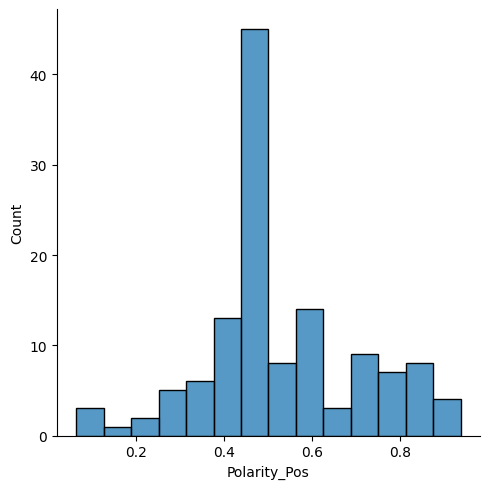

In [718]:
sns.displot(feeling['Polarity_Pos'])

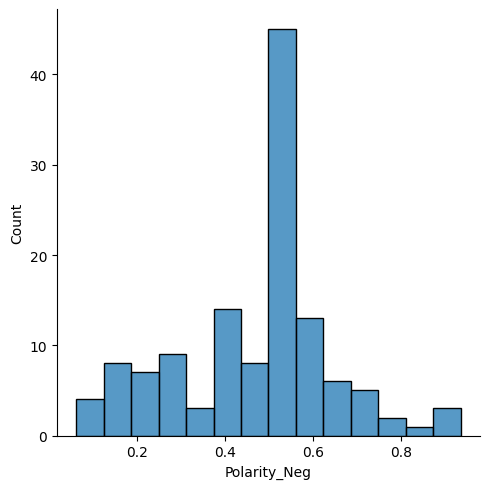

In [719]:
sns.displot(feeling['Polarity_Neg'])

In [705]:
fig = px.histogram(feeling[["Polarity_Pos",'Polarity_Neg']], x=["Polarity_Pos",'Polarity_Neg'], marginal="rug")
fig.show()

In [578]:
# We get the important words and their coef
x = pipeline_importada.named_steps['vect'].vocabulary_
coeficientes = pipeline_importada.named_steps['cls'].coef_[0]



{'graci': 439,
 'mar': 578,
 'pens': 700,
 'va': 947,
 'van': 953,
 'intent': 500,
 'sac': 831,
 'algui': 44,
 'ja': 512,
 'suen': 887,
 'ja ja': 513,
 'toc': 921,
 'dl': 298,
 'especial': 360,
 'buen': 118,
 'dia': 275,
 'primer': 751,
 'mand': 573,
 'abraz': 7,
 'grand': 443,
 'miguel': 607,
 'famili': 384,
 'hoy': 469,
 'podr': 722,
 'ser': 856,
 'human': 473,
 'buen dia': 119,
 'list': 552,
 'empez': 328,
 'congres': 197,
 'link': 549,
 'bdi': 104,
 'em': 325,
 'si': 866,
 'llev': 556,
 'lueg': 561,
 'orbyt': 674,
 'moment': 621,
 'dig': 284,
 'sistem': 876,
 'econom': 307,
 'recort': 798,
 'diner': 286,
 'social': 878,
 'medi': 592,
 'eur': 369,
 'banc': 100,
 'necesit': 645,
 'ajust': 36,
 'viern': 981,
 'rat': 785,
 'amig': 50,
 'univers': 943,
 'call': 130,
 'ayud': 94,
 'zapater': 997,
 'quier': 780,
 'algun': 45,
 'ultim': 939,
 'consej': 202,
 'ministr': 615,
 'consej ministr': 203,
 'denunci': 263,
 'respons': 813,
 'ere': 352,
 'cuatr': 231,
 'carg': 142,
 'emple': 330,
 '

In [638]:
df = pd.DataFrame([[key, x[key]] for key in x.keys()])
df.columns=['Palabra','Índice']

In [625]:
df1 = pd.DataFrame(coeficientes)
df1.columns=['COEF']

In [628]:
# We merge both dataset for visualizing 
result = pd.concat([df,df1], axis=1)
result


,Palabra,Índice,COEF
0,graci,439,-0.161174
1,mar,578,0.582204
2,pens,700,0.498377
3,va,947,-0.061534
4,van,953,0.195989
...,...,...,...
995,esperanzaon,363,0.628716
996,athletic,84,-0.929601
997,congresopp,198,-0.252745
998,votapp,989,0.864392


In [631]:
result['Relacion'] = np.where(result['COEF'].astype(str).str.contains('-'),'Negativo','Positivo')

In [636]:
result['COEF']=result['COEF'].abs()

In [646]:
result.sort_values(by='COEF', ascending=False).head(20)

,Palabra,Índice,COEF,Relacion
333,cart,147,1.860511,Negativo
340,abc_es,3,1.844937,Negativo
439,tim,916,1.805330,Negativo
118,blanc,110,1.675119,Negativo
390,eleg,321,1.473085,Negativo
106,gobiern,434,1.459033,Negativo
232,reduc,803,1.427234,Positivo
255,muj,633,1.402206,Positivo
110,aprob,68,1.368604,Positivo
630,tel,905,1.350257,Positivo


In [641]:
import eli5
eli5.show_weights(pipeline_importada.named_steps['cls'], vec=pipeline_importada.named_steps['vect'], top=20)


Weight?,Feature
+1.427,x232
+1.402,x255
+1.369,x110
+1.350,x630
+1.343,x194
+1.342,x263
+1.319,x798
+1.315,x489
+1.310,x228
+1.270,x221


In [507]:
weights = eli5.formatters.as_dataframe.explain_weights_df(pipeline_importada.named_steps['cls'], vec=pipeline_importada.named_steps['vect'])
features = weights['feature']
features

0       x232
1       x255
2       x110
3       x630
4       x194
        ... 
996     x390
997     x118
998     x439
999     x340
1000    x333
Name: feature, Length: 1001, dtype: object

3. How to improve the model?

I would rather change the Vect_stop_word, because is None, likely the model is cutting off this special words. Even, I would have used Random Forest or even Support Vector Machine, which can separate the two classes in better conditions. I would use more data for retrain my model to see how that improve.

And even, i would change the hiperparameters just in case those allow them, like max_features, now is 1000, so probably is going to be overfitting.

4. Where can we apply this model?

There are so many case where apply this case of work:

1.  Marketing comany, who needs to measures how the feedbacks o reviews on google maps, or even in trustpilot going on. This make you to have knowledge about their feeling.

2. Officer Police, who needs to know if the guilt is saying the thuth or not.

3. Chatbot at the School, which has been trained for answering different question to all students.

4. Robot, which has been trained for edearly people who are alone or just need some buddy for talking about whatever.

In [479]:
params = pipeline_importada.get_params()
params

{'memory': None,
 'steps': [('vect',
   CountVectorizer(max_df=0.5, max_features=1000, min_df=5, ngram_range=(1, 2))),
  ('cls', LogisticRegression(C=0.5))],
 'verbose': False,
 'vect': CountVectorizer(max_df=0.5, max_features=1000, min_df=5, ngram_range=(1, 2)),
 'cls': LogisticRegression(C=0.5),
 'vect__analyzer': 'word',
 'vect__binary': False,
 'vect__decode_error': 'strict',
 'vect__dtype': numpy.int64,
 'vect__encoding': 'utf-8',
 'vect__input': 'content',
 'vect__lowercase': True,
 'vect__max_df': 0.5,
 'vect__max_features': 1000,
 'vect__min_df': 5,
 'vect__ngram_range': (1, 2),
 'vect__preprocessor': None,
 'vect__stop_words': None,
 'vect__strip_accents': None,
 'vect__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vect__tokenizer': None,
 'vect__vocabulary': None,
 'cls__C': 0.5,
 'cls__class_weight': None,
 'cls__dual': False,
 'cls__fit_intercept': True,
 'cls__intercept_scaling': 1,
 'cls__l1_ratio': None,
 'cls__max_iter': 100,
 'cls__multi_class': 'auto',
 'cls__n_jobs': None,
